## Experiments for the course project

In [2]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/7f/85/b9c2fc5758abb2084e75a74ff4ee0152c2df661826eba3bc652a4cb559e4/xgboost-1.3.3-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from xgboost.sklearn import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, accuracy_score, recall_score, f1_score
from matplotlib import pyplot
from matplotlib.pyplot import figure
import numpy as np

In [4]:
x_train = pd.read_parquet('../dataset/labelencode_train.parquet')
x_test = pd.read_parquet('../dataset/labelencode_test.parquet')

In [5]:
cols = list(x_train.columns.values)
cols.remove('encounter_id')
cols.remove('diabetes_mellitus')

x_tr = x_train[cols].values
y_tr = x_train['diabetes_mellitus'].values
x_te = x_test[cols].values
y_te = x_test['diabetes_mellitus'].values

### Models
- best model (max_depth == 7)
- ## shorter max depth

In [6]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}

In [7]:
def run_experiment(model_param, attrib, attrib_list):
    pos_outcomes = {}
    for att in attrib_list:
        model_param[attrib] = att
        print(model_param)
        model = XGBClassifier(**model_param)
        model.fit(x_tr, y_tr)
        y_pred = model.predict_proba(x_te)
        pos_outcomes[att] = y_pred.copy()#y_pred[:, 1].copy()
    return pos_outcomes

In [12]:
# pos_outcomes = run_experiment(best_params, 'max_depth', [i for i in range(1, 10, 2)])
pos_outcomes = run_experiment(best_params, 'max_depth', [1, 2, 3, 4, 5, 6, 7, 8, 9])

{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 1, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}


/Users/grace/.pyenv/versions/3.7.6/envs/py_geo/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[14:46:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[14:46:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

In [13]:
np.argmax(pos_outcomes[7], axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
def draw_plot(outcomes, pos_prefix, title, file_name):
    # plot the roc curve for the model
    fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    rand_auc = [0 for _ in range(len(y_te))]
    ns_auc = roc_auc_score(y_te, rand_auc)
    print('Random: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_te, rand_auc)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')

    for k, p in outcomes.items():
        # calculate scores    
        xgb_auc = roc_auc_score(y_te, p[:, 1])
        print('XGBoost %s: ROC AUC=%.3f' % (k, xgb_auc))
        acc = accuracy_score(y_te, np.argmax(p, axis=1))
        print("Accuracy %s: %.3f"% (k, acc))
        recall = recall_score(y_te, np.argmax(p, axis=1))#, average='micro')
        print("Recall %s: %.3f"% (k, recall))     
        f1 = f1_score(y_te, np.argmax(p, axis=1))#, average='micro')
        print("F1 %s: %.3f"% (k, f1))     
        
        xgb_fpr, xgb_tpr, _ = roc_curve(y_te, p[:, 1])
        pyplot.plot(xgb_fpr, xgb_tpr, label=pos_prefix+str(k))

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.title(title)

    pyplot.show()
    fig.savefig(file_name)

Random: ROC AUC=0.500
XGBoost 1: ROC AUC=0.814
Accuracy 1: 0.813
Recall 1: 0.300
F1 1: 0.403
XGBoost 2: ROC AUC=0.835
Accuracy 2: 0.827
Recall 2: 0.391
F1 2: 0.486
XGBoost 3: ROC AUC=0.843
Accuracy 3: 0.831
Recall 3: 0.423
F1 3: 0.513
XGBoost 4: ROC AUC=0.849
Accuracy 4: 0.835
Recall 4: 0.450
F1 4: 0.534
XGBoost 5: ROC AUC=0.853
Accuracy 5: 0.836
Recall 5: 0.460
F1 5: 0.541
XGBoost 6: ROC AUC=0.856
Accuracy 6: 0.839
Recall 6: 0.472
F1 6: 0.551
XGBoost 7: ROC AUC=0.858
Accuracy 7: 0.840
Recall 7: 0.482
F1 7: 0.559
XGBoost 8: ROC AUC=0.858
Accuracy 8: 0.842
Recall 8: 0.487
F1 8: 0.563
XGBoost 9: ROC AUC=0.858
Accuracy 9: 0.838
Recall 9: 0.474
F1 9: 0.552


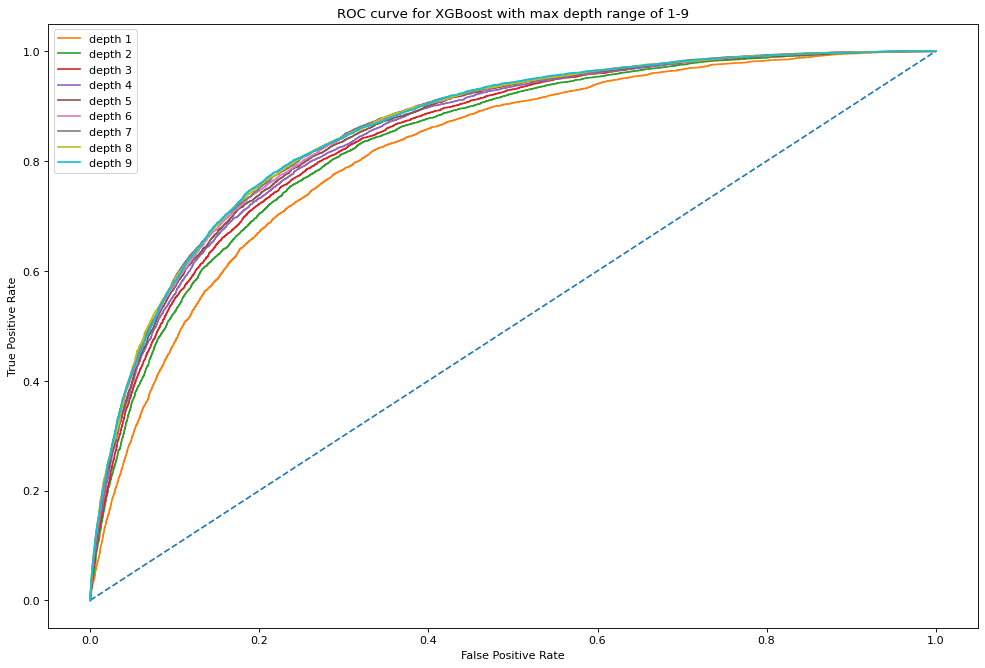

In [15]:
draw_plot(pos_outcomes, 'depth ', 'ROC curve for XGBoost with max depth range of 1-9', '../imgs/xgboost_labelencoding_depthvariations.png')

- ## learning rate

In [16]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
pos_outcomes = run_experiment(best_params, 'learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1])

{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.001, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}


/Users/grace/.pyenv/versions/3.7.6/envs/py_geo/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.005, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[14:54:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[14:55:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1

Random: ROC AUC=0.500
XGBoost 0.001: ROC AUC=0.822
Accuracy 0.001: 0.823
Recall 0.001: 0.412
F1 0.001: 0.494
XGBoost 0.005: ROC AUC=0.829
Accuracy 0.005: 0.827
Recall 0.005: 0.415
F1 0.005: 0.502
XGBoost 0.01: ROC AUC=0.837
Accuracy 0.01: 0.830
Recall 0.01: 0.427
F1 0.01: 0.514
XGBoost 0.05: ROC AUC=0.858
Accuracy 0.05: 0.840
Recall 0.05: 0.482
F1 0.05: 0.559
XGBoost 0.1: ROC AUC=0.859
Accuracy 0.1: 0.839
Recall 0.1: 0.485
F1 0.1: 0.558


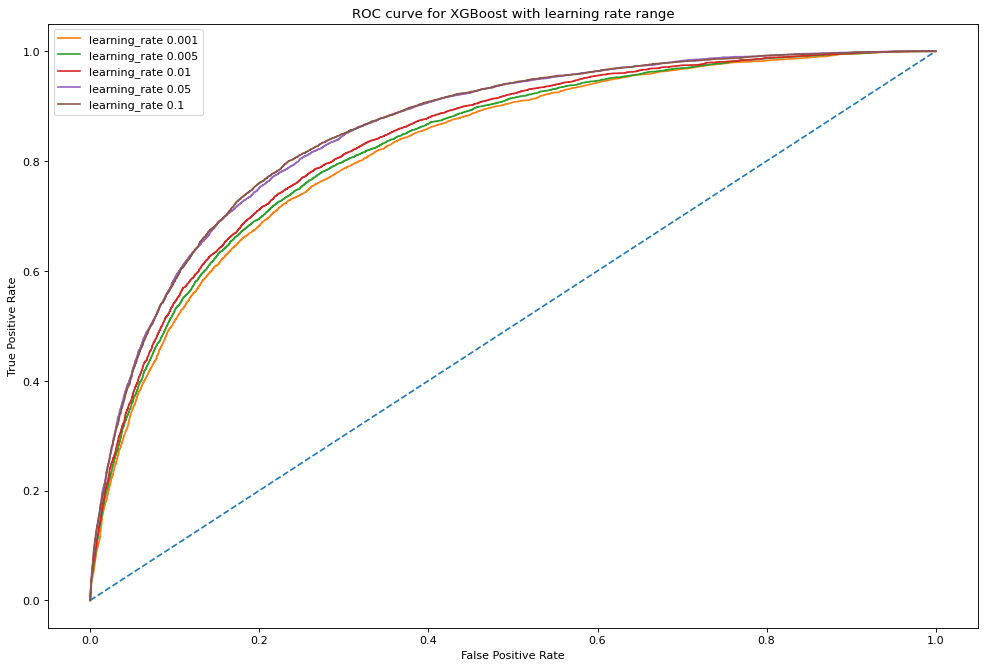

In [17]:
draw_plot(pos_outcomes, 'learning_rate ', 'ROC curve for XGBoost with learning rate range', '../imgs/xgboost_labelencoding_lrvariations.png')

## n_estimators

{'objective': 'binary:logistic', 'n_estimators': 140, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}


/Users/grace/.pyenv/versions/3.7.6/envs/py_geo/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 170, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[14:59:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 200, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[15:00:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

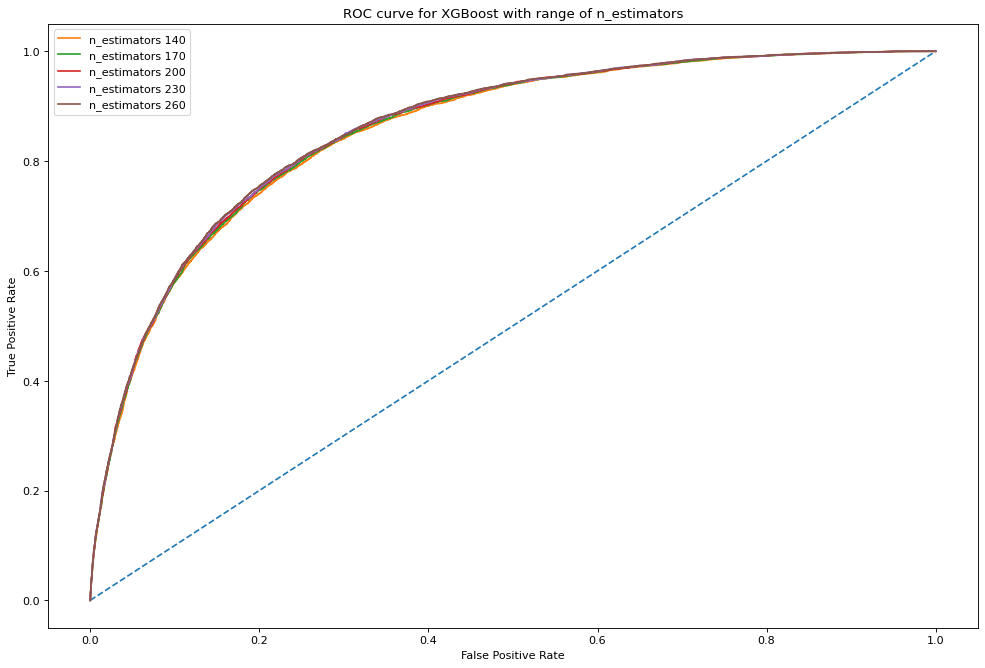

In [18]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
pos_outcomes = run_experiment(best_params, 'n_estimators', [140, 170, 200, 230, 260])
draw_plot(pos_outcomes, 'n_estimators ', 'ROC curve for XGBoost with range of n_estimators', '../imgs/xgboost_labelencoding_nevariations.png')

### min_child_weight

{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.2, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}


/Users/grace/.pyenv/versions/3.7.6/envs/py_geo/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[15:04:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.4, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
[15:05:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0,

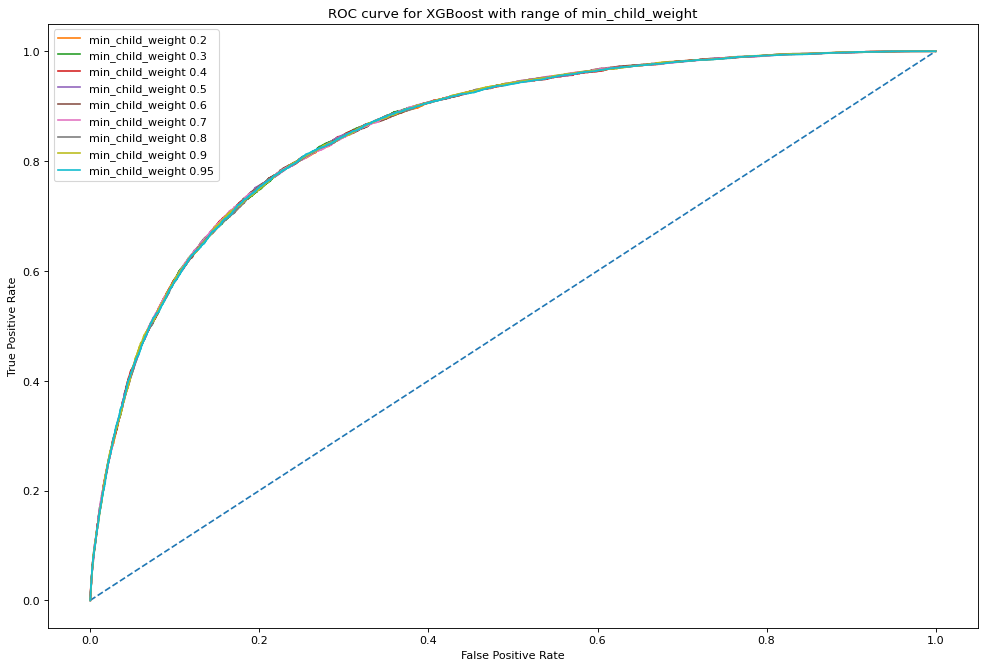

In [19]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
pos_outcomes = run_experiment(best_params, 'min_child_weight', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
draw_plot(pos_outcomes, 'min_child_weight ', 'ROC curve for XGBoost with range of min_child_weight', '../imgs/xgboost_labelencoding_mcvariations.png')